In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipaddress

from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## Data loading

In [3]:
col_names = ['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

def load_dataframe(name):
    return pd.read_csv(f"data/training/{name}_flows_cut.csv", header = None, names = col_names)

def load_test_dataframe(name):
    return pd.read_csv(f"data/test/{name}_flows_cut.csv", header = None, names = col_names)

In [4]:
background = load_dataframe("background")
blacklist  = load_dataframe("blacklist")
sshscan    = load_dataframe("sshscan")
spam       = load_dataframe("spam")

test_background = load_test_dataframe("background")
test_blacklist  = load_test_dataframe("blacklist")
test_sshscan    = load_test_dataframe("sshscan")
test_botnet     = load_test_dataframe("botnet")
test_scan11     = load_test_dataframe("scan11")
test_scan44     = load_test_dataframe("scan44")
test_spam       = load_test_dataframe("spam")
test_dos        = load_test_dataframe("dos")

attacks_dataframes = [blacklist, sshscan, spam]
test_attacks_dataframes = [test_blacklist, test_sshscan, test_botnet, test_scan11, test_scan44, test_spam, test_dos]

In [5]:
def cast_dataframe(df):
    # Convert timestamp to epoch integer
    df.end_epoch = pd.to_datetime(df.end_epoch).view(np.int64)

    # Convert attack to boolean
    df.attack = df.attack.apply(lambda x: x != 'background')

    # Convert IPs to int
    #df[["src_ip", "dst_ip"]] = df[["src_ip", "dst_ip"]].apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    df.src_ip = df.src_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))
    df.dst_ip = df.dst_ip.apply(lambda x: np.int64(ipaddress.IPv4Address(x)))

    return df

def get_dataframes(outlier_ratio, num_samples):
    nb_train_attack = int((num_samples * outlier_ratio - len(spam)) // (len(attacks_dataframes) - 1))
    nb_test_attack  = int((num_samples * outlier_ratio - len(test_sshscan)) // (len(test_attacks_dataframes) - 1))

    train_dataframes = [df.head(nb_train_attack) for df in attacks_dataframes]
    train_dataframes.append(background.head(num_samples - sum(len(df) for df in train_dataframes)))

    test_dataframes = [df.head(nb_test_attack) for df in test_attacks_dataframes]
    test_dataframes.append(test_background.head(num_samples - sum(len(df) for df in test_dataframes)))

    train_df = cast_dataframe(pd.concat(train_dataframes))
    test_df = cast_dataframe(pd.concat(test_dataframes))

    return train_df, test_df

In [6]:
df, test_df = get_dataframes(0.4, 200000)

In [7]:
print(f'Size of the dataset: {len(df)}\n')
print(f'Sumber of Nan values: {df.isnull().values.sum()}\n')
print(f'Column number: {len(df.columns)}\n')
print(f'Column names:\n{list(df.columns)}\n')
print('Column types:')
df.dtypes

Size of the dataset: 200000

Sumber of Nan values: 0

Column number: 13

Column names:
['end_epoch', 'duration', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'flags', 'status', 'service_type', 'packets', 'bytes', 'attack']

Column types:


end_epoch         int64
duration        float64
src_ip            int64
dst_ip            int64
src_port          int64
dst_port          int64
protocol         object
flags            object
status            int64
service_type      int64
packets           int64
bytes             int64
attack             bool
dtype: object

#### Control of flows

In [8]:
print(f"Number of background exchanges : {len(df[df.attack == False])}")
print(f"Number of attack: {len(df[df.attack])}")
print(f"Number of blacklisted IP attack: {len(blacklist)}")
print(f"Number of ssh scan attack: {len(sshscan)}")
print(f"Number of spam attack: {len(spam)}")

Number of background exchanges : 120001
Number of attack: 79999
Number of blacklisted IP attack: 500000
Number of ssh scan attack: 500000
Number of spam attack: 41


#### Numeric columns

In [9]:
numeric_df = df._get_numeric_data()
numeric_df.describe()

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes
count,2.000000e+05,200000.000000,2.000000e+05,2.000000e+05,200000.000000,200000.000000,200000.0,200000.000000,200000.000000,2.000000e+05
mean,1.460956e+18,3.686811,1.396791e+09,1.356781e+09,23300.856365,21241.312660,0.0,7.729560,20.632695,1.349295e+04
std,4.075974e+13,14.735915,1.021724e+09,9.942165e+08,24337.400565,24167.354843,0.0,18.507073,329.345748,3.443471e+05
min,1.460938e+18,0.000000,5.400010e+08,4.259593e+06,0.000000,0.000000,0.0,0.000000,1.000000,2.800000e+01
25%,1.460938e+18,0.000000,7.190356e+08,7.190356e+08,80.000000,53.000000,0.0,0.000000,1.000000,9.600000e+01
50%,1.460938e+18,0.780000,7.190363e+08,7.190363e+08,10549.500000,445.000000,0.0,0.000000,5.000000,6.140000e+02
75%,1.460938e+18,4.212000,1.487015e+09,1.301499e+09,48811.250000,46968.250000,0.0,8.000000,13.000000,1.846000e+03
max,1.461503e+18,355.724000,4.294738e+09,4.294738e+09,65535.000000,65535.000000,0.0,224.000000,57598.000000,8.617546e+07


## Dataset Visualisation

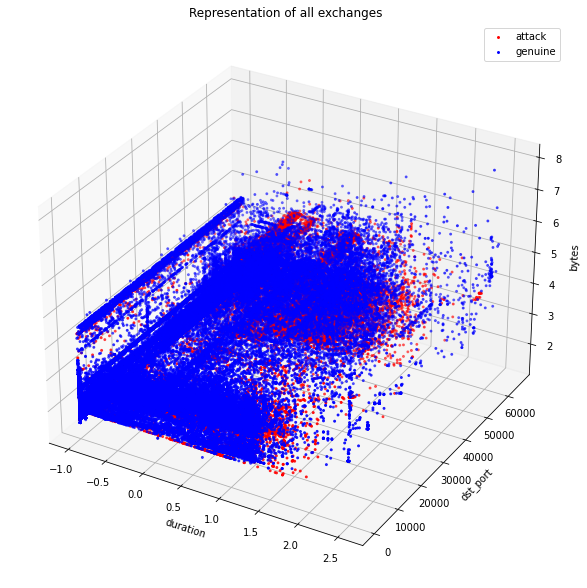

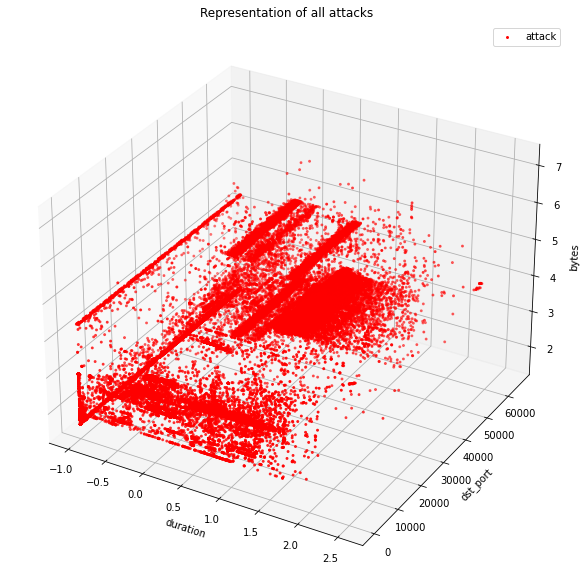

In [10]:
def show3D_flow_exchanges(df, x_axis, y_axis, z_axis, title):
    fig = plt.figure(figsize=(10,12))
    ax = fig.add_subplot(111, projection='3d')

    for attack in df.attack.unique():
        df_label = df[df.attack == attack]
        x = df_label[x_axis]
        y = df_label[y_axis]
        z = df_label[z_axis]
        ax.scatter(np.log10(x + 0.1), y, np.log10(z), color= 'red' if attack else 'blue' , label='attack' if attack else 'genuine', marker='.', s=15)

    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.set_zlabel(z_axis)
    ax.set_title(title)

    plt.legend()

show3D_flow_exchanges(df, 'duration', 'dst_port', 'bytes', 'Representation of all exchanges')
show3D_flow_exchanges(df[df.attack], 'duration', 'dst_port', 'bytes', 'Representation of all attacks')

## Data Cleaning

In [11]:
def one_hot_encoding_dataframes(df, test_df):
    one_hot_encoded_df = pd.get_dummies(df)
    one_hot_encoded_df_test = pd.get_dummies(test_df)

    one_hot_encoded_df_test['protocol_ESP'] = 0
    one_hot_encoded_df_test['protocol_GRE'] = 0
    one_hot_encoded_df_test['protocol_IPv6'] = 0

    return one_hot_encoded_df, one_hot_encoded_df_test

one_hot_encoded_df, one_hot_encoded_df_test = one_hot_encoding_dataframes(df, test_df)
display(one_hot_encoded_df.head())
print(one_hot_encoded_df.isna().sum().any())

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RS.,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,0,1,0,0,0,0
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,0,1,0,0,0,0
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,0,1,0,0,0,0
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,0,1,0,0,0,0
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,0


False


## Outlier detection

#### Isolation Forests

In [12]:
classifier = IsolationForest(contamination=0.4, n_estimators=2).fit(one_hot_encoded_df.values)
y_pred = classifier.predict(one_hot_encoded_df_test.values)

df_outliers = one_hot_encoded_df.copy()
df_outliers['if_outliers'] = [i == -1 for i in  y_pred]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,if_outliers
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,1,0,0,0,0,True
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,1,0,0,0,0,True
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,1,0,0,0,0,True
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,1,0,0,0,0,True
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119996,1460937805000000000,0.000,2964381342,719034815,38660,53,0,40,1,67,...,0,0,0,0,0,0,0,0,0,True
119997,1460937805000000000,0.000,2964381342,719034815,39355,53,0,40,1,67,...,0,0,0,0,0,0,0,0,0,True
119998,1460937805000000000,0.000,2964381342,719034815,41103,53,0,40,1,67,...,0,0,0,0,0,0,0,0,0,True
119999,1460937805000000000,0.000,2964381342,719034815,41408,53,0,40,1,67,...,0,0,0,0,0,0,0,0,0,True


In [13]:
def describe_precision(col):
    fraudulent_outliers = df_outliers[(df_outliers["attack"]) & (df_outliers[col])]
    print(f'{len(fraudulent_outliers)} attacks are labelled as outlier.')

    fraudulent_inliers = df_outliers[(df_outliers["attack"]) & (df_outliers[col] == False)]
    print(f'{len(fraudulent_inliers)} attacks are not labelled as outlier.')

    not_fraudulent_outliers = df_outliers[(df_outliers["attack"] == False) & (df_outliers[col])]
    print(f'{len(not_fraudulent_outliers)} genuine exchanges are labelled as outlier.')

    not_fraudulent_inliers = df_outliers[(df_outliers["attack"] == False) & (df_outliers[col] == False)]
    print(f'{len(not_fraudulent_inliers)} genuine exchanges are not labelled as outlier.')

In [14]:
describe_precision("if_outliers")

36570 attacks are labelled as outlier.
43429 attacks are not labelled as outlier.
98304 genuine exchanges are labelled as outlier.
21697 genuine exchanges are not labelled as outlier.


#### Local Outlier Factor

In [16]:
outlier_ratio = 0.4
df, test_df = get_dataframes(outlier_ratio, 15000)
one_hot_encoded_df, one_hot_encoded_df_test = one_hot_encoding_dataframes(df, test_df)

localOutlierFactor = LocalOutlierFactor(contamination=outlier_ratio, n_neighbors=len(df) - 1).fit(one_hot_encoded_df.values)

lof_outliers = localOutlierFactor.fit_predict(one_hot_encoded_df_test.values)

df_outliers = one_hot_encoded_df.copy()
df_outliers['lof_outliers'] = [i == -1 for i in  lof_outliers]
df_outliers

,end_epoch,duration,src_ip,dst_ip,src_port,dst_port,status,service_type,packets,bytes,...,flags_.A.RSF,flags_.AP...,flags_.AP..F,flags_.AP.S.,flags_.AP.SF,flags_.APR..,flags_.APR.F,flags_.APRS.,flags_.APRSF,lof_outliers
0,1460937736000000000,0.996,719036146,1010349080,33421,80,0,0,6,437,...,0,0,0,0,1,0,0,0,0,True
1,1460937736000000000,0.852,719036146,1010349080,35297,443,0,0,52,3030,...,0,0,0,0,1,0,0,0,0,True
2,1460937737000000000,0.936,1010349080,719036146,80,33421,0,0,4,565,...,0,0,0,0,1,0,0,0,0,True
3,1460937737000000000,0.804,1010349080,719036146,443,35297,0,0,72,86267,...,0,0,0,0,1,0,0,0,0,True
4,1460937750000000000,0.000,719034610,1489856190,38531,25,0,0,1,60,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,1460937739000000000,0.000,2403862665,719035623,53,39895,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False
8997,1460937739000000000,0.000,2403862665,719035623,53,39992,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False
8998,1460937739000000000,0.000,2403862665,719035623,53,40001,0,0,1,131,...,0,0,0,0,0,0,0,0,0,False
8999,1460937739000000000,0.000,2403862665,719035623,53,40190,0,0,1,125,...,0,0,0,0,0,0,0,0,0,False


In [17]:
describe_precision("lof_outliers")

5998 attacks are labelled as outlier.
1 attacks are not labelled as outlier.
0 genuine exchanges are labelled as outlier.
9001 genuine exchanges are not labelled as outlier.


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

labels = one_hot_encoded_df['attack']
labels_test = one_hot_encoded_df_test['attack']

classifier = RandomForestClassifier()
classifier.fit(one_hot_encoded_df, labels)
classifier.score(one_hot_encoded_df_test, labels_test)

/home/leiyks/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


1.0